In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, LSTM
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split

%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#Load the drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
columns = ['user', 'activity', 'timestamp', 'x-axis', 'y-axis', 'z-axis']
df = pd.read_csv('/content/drive/MyDrive/WISDM_ar_v1.1_raw.txt', header=None, names=columns)
df = df.dropna()
df.head()

,user,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1098203 entries, 0 to 1098203
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user       1098203 non-null  int64  
 1   activity   1098203 non-null  object 
 2   timestamp  1098203 non-null  int64  
 3   x-axis     1098203 non-null  float64
 4   y-axis     1098203 non-null  float64
 5   z-axis     1098203 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 58.7+ MB


# Exploration

In [ ]:
countOfActivity = df['activity'].value_counts()
print(countOfActivity)

Walking       424397
Jogging       342176
Upstairs      122869
Downstairs    100427
Sitting        59939
Standing       48395
Name: activity, dtype: int64


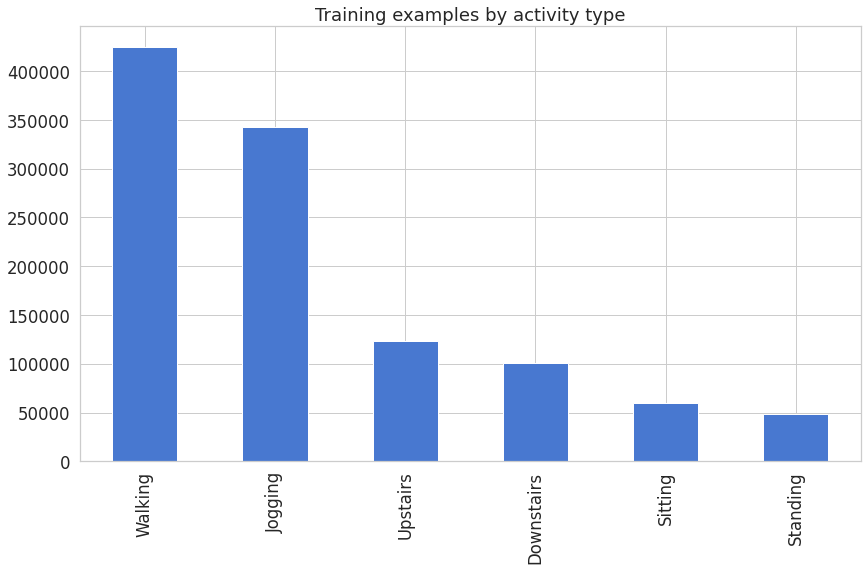

In [ ]:
countOfActivity.plot(kind='bar', title='Training examples by activity type', figsize = (14,8))

# No of samples belonging to each volunteer


In [ ]:
countOfActivityPerPerson = df['user'].value_counts()
print(countOfActivityPerPerson)
totalActivity = countOfActivityPerPerson.sum()
print("Total number of activity recorded = " + str(totalActivity))

20    56632
19    45383
31    44282
8     41188
29    38245
14    38192
13    37093
34    35947
32    35506
21    35436
3     35161
27    34958
10    34883
18    32811
12    32641
26    32578
36    32261
11    31658
7     30967
1     29978
6     29704
33    29453
5     28509
15    28154
24    25736
23    25673
30    25335
2     23525
35    22394
22    22310
17    22020
28    21358
16    20470
25    13468
9     12923
4     11371
Name: user, dtype: int64
Total number of activity recorded = 1098203


In [ ]:
N_TIME_STEPS = 200
N_FEATURES = 3
step = 20
segments = []
labels = []
for i in range(0, len(df) - N_TIME_STEPS, step):
  xs = df['x-axis'].values[i: i + N_TIME_STEPS]
  ys = df['y-axis'].values[i: i + N_TIME_STEPS]
  zs = df['z-axis'].values[i: i + N_TIME_STEPS]
  label = stats.mode(df['activity'][i: i + N_TIME_STEPS])
  label = label[0][0] #to get actual value of node
  segments.append([xs,ys,zs])
  labels.append(label)

In [ ]:
np.array(segments).shape

(54901, 3, 200)

In [ ]:
reshape_segments = np.asarray(segments, dtype = np.float32).reshape(-1, N_TIME_STEPS, N_FEATURES)
reshape_segments.shape

(54901, 200, 3)

In [ ]:
print(reshape_segments)

[[[ -0.6946377    5.012288     4.903325  ]
  [ -0.61291564  -1.1849703    1.3756552 ]
  [ -0.61291564  -0.50395286  -8.430995  ]
  ...
  [  7.6273947   -8.349273     9.575105  ]
  [  2.2201166    4.4810944    0.08172209]
  [ -5.8567495    7.1234417   -9.112013  ]]

 [[  3.568531    -0.50395286  -2.3018389 ]
  [ -3.568531    -0.8036005    0.50395286]
  [  5.706926    -8.662541    -1.334794  ]
  ...
  [  6.851035    -8.19945     -1.8387469 ]
  [  2.982856     3.1054392    0.88532263]
  [  8.349273    -2.982856    15.4046135 ]]

 [[  5.6660647    0.23154591  -4.8216033 ]
  [  1.8387469   -3.2961242   11.604536  ]
  [ -3.173541     0.61291564  -7.8861814 ]
  ...
  [-11.536434    -8.812365     4.2904096 ]
  [  2.2201166    8.349273     5.7886477 ]
  [ -9.888372     1.7978859   -1.334794  ]]

 ...

 [[  9.           9.04         9.04      ]
  [  9.04         9.           9.04      ]
  [  9.11         9.08         9.08      ]
  ...
  [  2.26         2.26         2.3       ]
  [  2.3          

#Encoding labels(Walking,Sitting,Jogging etc..)

In [ ]:
labels = np.asarray(pd.get_dummies(labels), dtype=np.float32)

In [ ]:
print(labels)
print(labels.shape)

[[0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 ...
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]]
(54901, 6)


# Train-Test spliting

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    reshape_segments, labels, test_size=0.2, random_state=42
)

In [ ]:
X_test.shape

(10981, 200, 3, 1)

In [ ]:
labels.shape[1]

6

In [ ]:
X_train = X_train.reshape(43920, 200, 3, 1)
X_test = X_test.reshape(10981, 200, 3, 1)
X_train.shape[1]


200

# Building the Convolutional Neural Network(2D CNN)


In [ ]:
model = Sequential()
model.add(Conv2D(128, (2,2), input_shape=(200, 3, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), padding='valid'))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(6, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 199, 2, 128)       640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 1, 128)        0         
_________________________________________________________________
dropout (Dropout)            (None, 99, 1, 128)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12672)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               1622144   
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 7

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=10, verbose=2)

Epoch 1/10
4392/4392 - 42s - loss: 0.4504 - accuracy: 0.8384 - val_loss: 0.3056 - val_accuracy: 0.8873
Epoch 2/10
4392/4392 - 10s - loss: 0.2356 - accuracy: 0.9133 - val_loss: 0.2534 - val_accuracy: 0.9103
Epoch 3/10
4392/4392 - 10s - loss: 0.1745 - accuracy: 0.9364 - val_loss: 0.1981 - val_accuracy: 0.9262
Epoch 4/10
4392/4392 - 10s - loss: 0.1394 - accuracy: 0.9497 - val_loss: 0.1822 - val_accuracy: 0.9377
Epoch 5/10
4392/4392 - 10s - loss: 0.1165 - accuracy: 0.9584 - val_loss: 0.1875 - val_accuracy: 0.9362
Epoch 6/10
4392/4392 - 9s - loss: 0.1019 - accuracy: 0.9645 - val_loss: 0.1851 - val_accuracy: 0.9425
Epoch 7/10
4392/4392 - 10s - loss: 0.0919 - accuracy: 0.9671 - val_loss: 0.1718 - val_accuracy: 0.9459
Epoch 8/10
4392/4392 - 10s - loss: 0.0861 - accuracy: 0.9712 - val_loss: 0.1424 - val_accuracy: 0.9546
Epoch 9/10
4392/4392 - 10s - loss: 0.0769 - accuracy: 0.9735 - val_loss: 0.1947 - val_accuracy: 0.9464
Epoch 10/10
4392/4392 - 10s - loss: 0.0702 - accuracy: 0.9765 - val_loss: 

In [ ]:
model.save('models/model.h5')

# Building LSTM (Long Short Term Memory) Model

In [ ]:

model_1 = Sequential()
model_1.add(LSTM(units=32, return_sequences='True', input_shape=(200,3)))
model_1.add(Dropout(0.2))
model_1.add(LSTM(units=32, return_sequences='True'))
model_1.add(Dropout(0.2))
model_1.add(LSTM(units=32, return_sequences='True'))
model_1.add(Dropout(0.2))
model_1.add(LSTM(units=32, return_sequences='True'))
model_1.add(Dropout(0.2))
model_1.add(Flatten())
model_1.add(Dense(units=6, activation='sigmoid'))
model_1.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_20 (LSTM)               (None, 200, 32)           4608      
_________________________________________________________________
dropout_19 (Dropout)         (None, 200, 32)           0         
_________________________________________________________________
lstm_21 (LSTM)               (None, 200, 32)           8320      
_________________________________________________________________
dropout_20 (Dropout)         (None, 200, 32)           0         
_________________________________________________________________
lstm_22 (LSTM)               (None, 200, 32)           8320      
_________________________________________________________________
dropout_21 (Dropout)         (None, 200, 32)           0         
_________________________________________________________________
lstm_23 (LSTM)               (None, 200, 32)          

In [ ]:
model_1.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [ ]:
X_train = X_train.reshape(43920, 200, 3)
X_test = X_test.reshape(10981, 200, 3)
model_1.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=10, epochs=10, verbose=2)

Epoch 1/10
4392/4392 - 108s - loss: 0.0367 - accuracy: 0.8492 - val_loss: 0.0287 - val_accuracy: 0.8847
Epoch 2/10
4392/4392 - 104s - loss: 0.0207 - accuracy: 0.9197 - val_loss: 0.0162 - val_accuracy: 0.9396
Epoch 3/10
4392/4392 - 104s - loss: 0.0148 - accuracy: 0.9452 - val_loss: 0.0120 - val_accuracy: 0.9574
Epoch 4/10
4392/4392 - 104s - loss: 0.0116 - accuracy: 0.9576 - val_loss: 0.0111 - val_accuracy: 0.9573
Epoch 5/10
4392/4392 - 103s - loss: 0.0101 - accuracy: 0.9636 - val_loss: 0.0097 - val_accuracy: 0.9649
Epoch 6/10
4392/4392 - 104s - loss: 0.0086 - accuracy: 0.9688 - val_loss: 0.0086 - val_accuracy: 0.9692
Epoch 7/10
4392/4392 - 104s - loss: 0.0077 - accuracy: 0.9723 - val_loss: 0.0076 - val_accuracy: 0.9718
Epoch 8/10
4392/4392 - 103s - loss: 0.0069 - accuracy: 0.9755 - val_loss: 0.0070 - val_accuracy: 0.9761
Epoch 9/10
4392/4392 - 103s - loss: 0.0059 - accuracy: 0.9793 - val_loss: 0.0081 - val_accuracy: 0.9718
Epoch 10/10
4392/4392 - 104s - loss: 0.0055 - accuracy: 0.9812 -

In [ ]:
model_1.save('models/model_1.h5')

# Building MLP (Multi-Layer Perceptron) Model

In [ ]:
model_2 = Sequential()
model_2.add(Dense(128, activation='relu', input_shape=(200,3,1)))
model_2.add(Dropout(0.2))
model_2.add(Dense(128, activation='relu'))
model_2.add(Dropout(0.2))
model_2.add(Dense(64, activation='relu'))
model_2.add(Dropout(0.2))
model_2.add(Flatten())
model_2.add(Dense(6, activation='softmax'))
model_2.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_42 (Dense)             (None, 200, 3, 128)       256       
_________________________________________________________________
dropout_45 (Dropout)         (None, 200, 3, 128)       0         
_________________________________________________________________
dense_43 (Dense)             (None, 200, 3, 128)       16512     
_________________________________________________________________
dropout_46 (Dropout)         (None, 200, 3, 128)       0         
_________________________________________________________________
dense_44 (Dense)             (None, 200, 3, 64)        8256      
_________________________________________________________________
dropout_47 (Dropout)         (None, 200, 3, 64)        0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 38400)           

In [ ]:
X_train = X_train.reshape(43920, 200, 3, 1)
X_test = X_test.reshape(10981, 200, 3, 1)
model_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model_2.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=10, epochs=10, verbose=2)

Epoch 1/10
4392/4392 - 11s - loss: 0.7602 - accuracy: 0.7367 - val_loss: 0.5913 - val_accuracy: 0.7787
Epoch 2/10
4392/4392 - 11s - loss: 0.5579 - accuracy: 0.7995 - val_loss: 0.5359 - val_accuracy: 0.8122
Epoch 3/10
4392/4392 - 11s - loss: 0.5095 - accuracy: 0.8152 - val_loss: 0.6741 - val_accuracy: 0.7495
Epoch 4/10
4392/4392 - 11s - loss: 0.4760 - accuracy: 0.8257 - val_loss: 0.6133 - val_accuracy: 0.7754
Epoch 5/10
4392/4392 - 11s - loss: 0.4545 - accuracy: 0.8322 - val_loss: 0.5986 - val_accuracy: 0.7793
Epoch 6/10
4392/4392 - 11s - loss: 0.4375 - accuracy: 0.8386 - val_loss: 0.6139 - val_accuracy: 0.7713
Epoch 7/10
4392/4392 - 11s - loss: 0.4261 - accuracy: 0.8427 - val_loss: 0.6724 - val_accuracy: 0.7467
Epoch 8/10
4392/4392 - 11s - loss: 0.4177 - accuracy: 0.8435 - val_loss: 0.6410 - val_accuracy: 0.7649
Epoch 9/10
4392/4392 - 11s - loss: 0.4078 - accuracy: 0.8473 - val_loss: 0.6030 - val_accuracy: 0.7766
Epoch 10/10
4392/4392 - 11s - loss: 0.4017 - accuracy: 0.8502 - val_loss: